# Toader Liviu Eduard - Group 407

Import packages for reading files.

In [1]:
import glob
import os

Import NLTK for text preprocessing.

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.probability import FreqDist

## Data
There are 9 files in the 'data' directory.  
Each file represents a document and has around 30 words.  
There are 3 documents with the topic chemistry, 3 astronomy, 3 artificial intelligence. 
  
Read the files, tokenize the input strings with NLTK and add them to the 'collection' list.  
The list 'collection' will contain all documents. A 'document' is a list of strings that represent the words.

In [3]:
collection = []
file_list = glob.glob(os.path.join(os.getcwd(), 'data', '*.txt'))
for file_path in file_list:
    with open(file_path) as f:
        document = f.read()
        document = word_tokenize(document)
        collection.append(document)

Print the first document to see how it looks.

In [4]:
collection[0]

['Oxygen',
 'is',
 'a',
 'chemical',
 'element',
 'with',
 '8',
 'protons',
 'and',
 '8',
 'neutrons',
 'in',
 'the',
 'nucleus',
 '.',
 'Oxygen',
 'has',
 '8',
 'electrons',
 'outside',
 'the',
 'nucleus',
 '.',
 'Oxygen',
 'has',
 'more',
 'electrons',
 'than',
 'hydrogen',
 '.',
 'Oxygen',
 'can',
 'form',
 'water',
 'with',
 'hydrogen',
 '.']

## Preprocessing

To get rid of irrelevant input, I use the following preprocessing techniques:
- remove non-alpha (numbers and punctuation)
- make words lowercase
- remove stop words
- lemmatization
- keep only relevant parts of speech
  
To see which parts of speech to keep, print the words from the first document and their type.

In [5]:
pos_tag(collection[0])

[('Oxygen', 'NN'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('chemical', 'JJ'),
 ('element', 'NN'),
 ('with', 'IN'),
 ('8', 'CD'),
 ('protons', 'NNS'),
 ('and', 'CC'),
 ('8', 'CD'),
 ('neutrons', 'NNS'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('nucleus', 'NN'),
 ('.', '.'),
 ('Oxygen', 'NNP'),
 ('has', 'VBZ'),
 ('8', 'CD'),
 ('electrons', 'NNS'),
 ('outside', 'IN'),
 ('the', 'DT'),
 ('nucleus', 'NN'),
 ('.', '.'),
 ('Oxygen', 'NN'),
 ('has', 'VBZ'),
 ('more', 'JJR'),
 ('electrons', 'NNS'),
 ('than', 'IN'),
 ('hydrogen', 'NN'),
 ('.', '.'),
 ('Oxygen', 'NN'),
 ('can', 'MD'),
 ('form', 'VB'),
 ('water', 'NN'),
 ('with', 'IN'),
 ('hydrogen', 'NN'),
 ('.', '.')]

Nouns (NN), adjectives (JJ) and gerund verbs (VBG) seem to be the most relevant. The other parts of speech will be removed.  

Prepare the changes by also creating a stop word list and a lemmatizer.

In [6]:
part_of_speech = ['NN', 'NNS', 'JJ', 'VBG']
stop_words = stopwords.words('english')
lemma = WordNetLemmatizer()

Now do the preprocessing for all documents.

In [7]:
for document in collection:
    document[:] = [word for word in document if word.isalpha()]
    document[:] = [word.lower() for word in document]
    document[:] = [word for word in document if word not in stop_words]
    document[:] = [lemma.lemmatize(word) for word in document]
    document[:] = pos_tag(document)
    document[:] = [word[0] for word in document if word[1] in part_of_speech]

Print the first document to see how it looks after the preprocessing.

In [8]:
collection[0]

['oxygen',
 'chemical',
 'element',
 'proton',
 'neutron',
 'nucleus',
 'oxygen',
 'electron',
 'nucleus',
 'oxygen',
 'electron',
 'hydrogen',
 'oxygen',
 'form',
 'water',
 'hydrogen']

Let's see what are the first 25 most common words in the collection and how many times they appear.

In [9]:
fdist = FreqDist([word for document in collection for word in document])
most_common_words = fdist.most_common(25)
most_common_words

[('planet', 9),
 ('intelligence', 9),
 ('oxygen', 8),
 ('hydrogen', 8),
 ('artificial', 7),
 ('learning', 6),
 ('electron', 5),
 ('sun', 5),
 ('earth', 5),
 ('moon', 5),
 ('machine', 5),
 ('algorithm', 5),
 ('nucleus', 4),
 ('water', 4),
 ('solar', 4),
 ('system', 4),
 ('chemical', 3),
 ('element', 3),
 ('proton', 3),
 ('neutron', 3),
 ('mercury', 3),
 ('venus', 3),
 ('human', 3),
 ('reasoning', 3),
 ('problem', 3)]

The less frequent words are removed from the documents.

In [10]:
most_common_words = [word[0] for word in most_common_words]

for document in collection:
    document[:] = [word for word in document if word in most_common_words]

Now that the preprocessing is completely done, create a vocabulary of the remaining words.  
Each word will have an ID assigned to it.

In [11]:
vocabulary = {}
id = 0
for document in collection:
    for word in document:
        if (word not in vocabulary):
            vocabulary[word] = id
            id += 1

Replace the words in documents with their ID to prepare them for the LDA algorithm.

In [12]:
for document in collection:
    document[:] = [vocabulary.get(word) for word in document]

Print the first document to see the word IDs.

In [13]:
collection[0]

[0, 1, 2, 3, 4, 5, 0, 6, 5, 0, 6, 7, 0, 8, 7]

## Latent Dirichlet Allocation 

Manually set the number of topics K to 3.

In [14]:
import numpy as np
import pymc as pm

collection = np.array(collection)

K = 3
V = len(vocabulary)
D = len(collection)

V, D

(25, 9)

Set hyperparameters alpha and beta.  
After experimenting with multiple numbers, 0.5 and 1 seem to give the best results for my data.  
I also tried lowering beta to 0.5 but the results became too chaotic.

In [15]:
alpha = np.full(K, 0.5)
beta = np.full(V, 1)
alpha, beta

(array([0.5, 0.5, 0.5]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]))

$\varphi_k \sim Dir(\beta), 1 \leq k \leq K$

In [16]:
phi_incomplete = pm.Container([
    pm.Dirichlet(
        name = 'phi_i_%i' % topic,
        theta = beta)
    for topic in range(K)])

phi = pm.Container([
    pm.CompletedDirichlet(
        name = 'phi_%i' % topic,
        D = phi_incomplete[topic])
    for topic in range(K)])

$\theta_m \sim Dir(\alpha), 1 \leq m \leq M$

In [17]:
theta_incomplete = pm.Container([
    pm.Dirichlet(
        name = 'theta_i_%i' % document, 
        theta = alpha) 
    for document in range(D)])

theta = pm.Container([
    pm.CompletedDirichlet(
        name = 'theta_%i' % document, 
        D = theta_incomplete[document]) 
    for document in range(D)])

$z_{m,n} \sim Multinomial(\theta_m), 1 \leq m \leq M, 1 \leq n \leq N_m$

In [18]:
word_count = [len(document) for document in collection]

z = pm.Container([
     pm.Categorical(
         name = 'z_%i' % document,
         p = theta[document],
         size = word_count[document],
         value = np.random.randint(K, size=word_count[document]))
     for document in range(D)])

$w_{m,n} \sim Multinomial(\varphi_{z_{m,n}}), 1 \leq m \leq M, 1 \leq n \leq N_m$

In [19]:
w = pm.Container([
     pm.Categorical(
         name = 'w_%i_%i' % (document, word),
         p = pm.Lambda(
             name = 'phi_z_%i_%i' % (document, word),
             lam_fun = lambda index=z[document][word], phi=phi: phi[index]),
         value = collection[document][word],
         observed = True)
     for document in range(D) for word in range(word_count[document])])

In [20]:
mcmc = pm.MCMC([phi_incomplete, phi, theta_incomplete, theta, z, w])
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 213.8 sec

## Results  
  
  
Print the topic distribution for each document.

In [21]:
np.set_printoptions(precision=4, suppress=True)

for document in range(D):
    print('Document %i:' % document, mcmc.trace('theta_%i'%document)[-101:-1].mean(axis=0)[0]) 

Document 0: [0.9916 0.0017 0.0067]
Document 1: [0.979  0.0037 0.0173]
Document 2: [0.8658 0.1189 0.0153]
Document 3: [0.0428 0.9378 0.0194]
Document 4: [0.0067 0.9786 0.0147]
Document 5: [0.0031 0.9739 0.023 ]
Document 6: [0.0009 0.0585 0.9406]
Document 7: [0.0101 0.0233 0.9666]
Document 8: [0.0204 0.0139 0.9657]


Plot the topic distribution for each document.

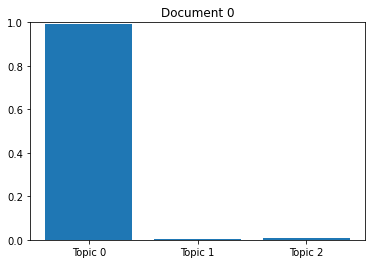

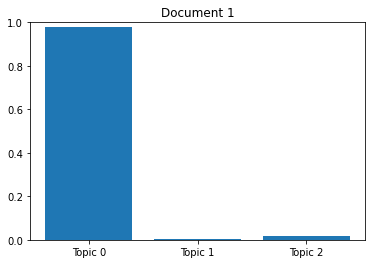

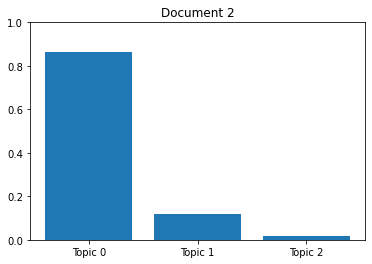

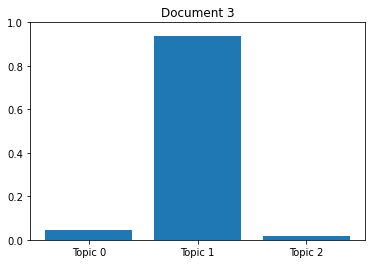

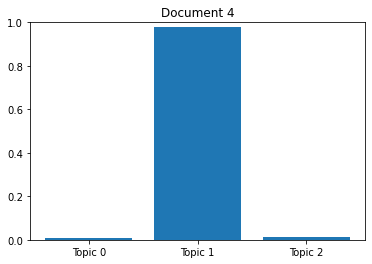

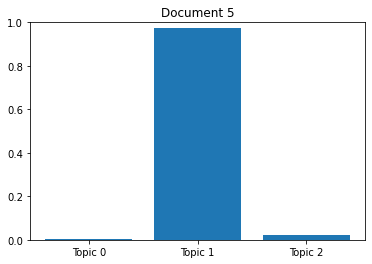

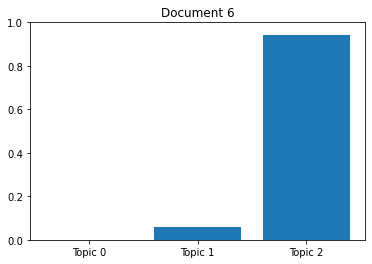

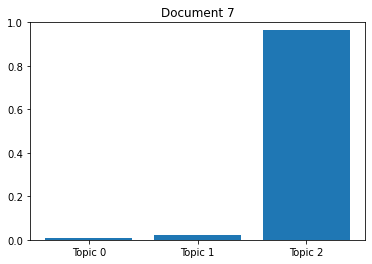

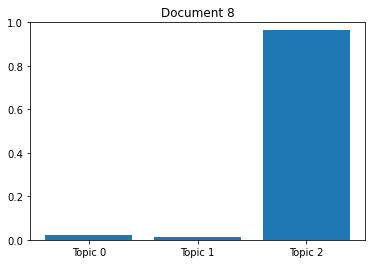

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

for document in range(D):
    topic = ['Topic %i'%topic for topic in range(K)]
    probability = mcmc.trace('theta_%i'%document)[-101:-1].mean(axis=0)[0]
    
    fig, ax = plt.subplots()
    ax.bar(topic, probability)
    ax.set_title('Document %i' % document)
    plt.ylim(0, 1)
    plt.show()

Print the top 5 words of each topic.

In [23]:
from operator import itemgetter

inverted_vocabulary = {value: word for word, value in vocabulary.items()}

for topic in range(K):
    probability = []
    for i, j in enumerate(mcmc.trace('phi_%i'%topic)[-101:-1].mean(axis=0)[0]):
        probability.append((inverted_vocabulary[i], j))
    probability.sort(key=itemgetter(1), reverse=True)
    
    print('Topic %i:' % topic)
    for i in range(5):
        print('\t', probability[i][0], ':', '%.4f' % probability[i][1])

Topic 0:
	 hydrogen : 0.1707
	 oxygen : 0.1454
	 electron : 0.1376
	 water : 0.1060
	 nucleus : 0.0548
Topic 1:
	 planet : 0.1944
	 earth : 0.1371
	 moon : 0.1171
	 system : 0.0748
	 solar : 0.0695
Topic 2:
	 artificial : 0.1707
	 algorithm : 0.1480
	 intelligence : 0.1418
	 learning : 0.1292
	 reasoning : 0.0589


Plot the word distribution for each topic.

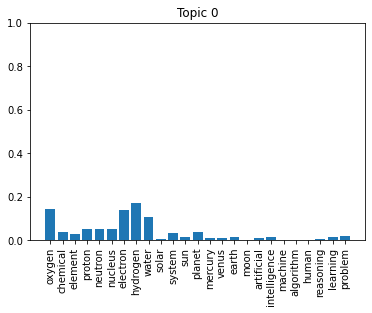

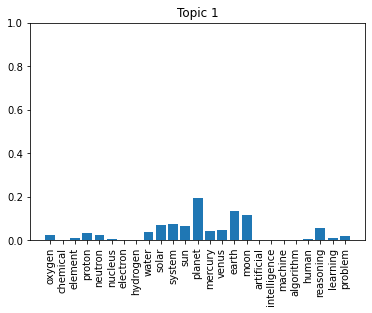

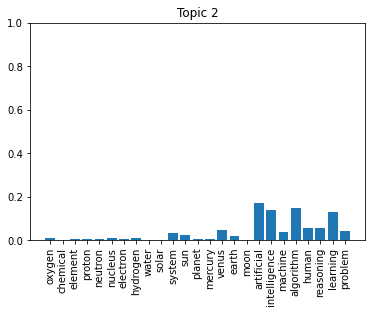

In [24]:
for topic in range(K):
    word_probability = []
    for i, j in enumerate(mcmc.trace('phi_%i'%topic)[-101:-1].mean(axis=0)[0]):
        word_probability.append((inverted_vocabulary[i], j))
        
    word = [word[:][0] for word in word_probability]
    probability = [probability[:][1] for probability in word_probability]
    
    fig, ax = plt.subplots()
    ax.bar(word, probability)
    ax.set_title("Topic %i" % topic)
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.show()

## Can the topic model be used to define a topic-based similarity measure between documents?

Yes. The similarity between documents can be calculated by comparing their distributions with Kullback-Leibler or Jensen-Shannon divergence.

For example, let's see how similar are documents 0 and 1. Their Jensen-Shannon score should be low because they both contain words from the same topic (chemistry).

In [25]:
from scipy.spatial import distance

theta_0 = mcmc.trace('theta_0')[-101:-1].mean(axis=0)[0]
theta_1 = mcmc.trace('theta_1')[-101:-1].mean(axis=0)[0]

print('%.4f' % distance.jensenshannon(theta_0, theta_1))

0.0375


Now let's compare document 0 (which is about chemistry) to document 8 (artificial intelligence).

In [26]:
theta_8 = mcmc.trace('theta_8')[-101:-1].mean(axis=0)[0]

print('%.4f' % distance.jensenshannon(theta_0, theta_8))

0.7877


We can see that similar documents have low values, while non-related documents have high values.

## What about a new document? How can topics be assigned to it?

A new document can be created by randomly giving it words from the word distribution of a topic.  
  
Let's create a new document with 50 words from the first topic.

In [27]:
word_probability = []
for i, j in enumerate(mcmc.trace('phi_0')[-101:-1].mean(axis=0)[0]):
    word_probability.append((inverted_vocabulary[i], j))
    
word = [word[:][0] for word in word_probability]
probability = [word[:][1] for word in word_probability]

new_document = np.random.choice(word, 50, probability)
new_document = ' '.join([str(word) for word in new_document])
new_document

'planet electron element nucleus hydrogen hydrogen artificial sun learning system artificial water human intelligence oxygen venus water learning reasoning neutron electron hydrogen element mercury water artificial oxygen electron solar planet learning solar earth human element water problem artificial machine electron proton oxygen solar sun system artificial water artificial problem proton'